In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
sys.path.append("../../../work2/ownutils/scriptssyn") #rosamc/scriptssyn repo
sys.path.append("./bin/")
import PolAB_A_allpars

import networkx as nx
import matplotlib as mpl
mpl.rcParams['font.size']=12
import fluxes
import clusteringaux
import basic
import glob
import itertools
import matplotlib.colors as colors
import seaborn as sns

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
rhofunc=PolAB_A_allpars.interface_rhos_GRF_PolAB_A_A
parsliststr='ktia0,ktan0,ktin0,ktni0,ktiaA,ktanA,ktinA,ktniA,ktiaB,ktanB,ktinB,ktniB,kbBa,kuBa,kbBi,kuBi,kbBn,kuBn,kbAa,kuAa,kbAi,kuAi,kbAn,kuAn'
parslist=parsliststr.split(',')
parslist_order=['ktni0','ktin0','ktia0','ktan0','ktniA','ktinA','ktiaA','ktanA','ktniB','ktinB','ktiaB','ktanB','kbBa','kuBa','kbBi','kuBi','kbBn','kuBn','kbAa','kuAa','kbAi','kuAi','kbAn','kuAn']
flux_order_labs=['2-1','1-2','1-0','0-2','5-4','4-5','4-3','3-5','8-7','7-8','7-6','6-8','2-5','5-2','2-8','8-2','1-4','4-1','1-7','7-1','0-3','3-0','0-6','6-0']

#labls=np.array(parslist[:18])

#copied from 2019_05_14_prepare_3statepol-equalb

edges=[(2,'ktia0',1),(1,'ktan0',3),(2,'ktin0',3),(3,'ktni0',2),
       (8,'ktiaA',7),(7,'ktanA',9),(8,'ktinA',9),(9,'ktniA',8),
       (5,'ktiaB',4),(4,'ktanB',6),(5,'ktinB',6),(6,'ktniB',5),
      (1,'kbBa-B',4),(4,'kuBa',1),(2,'kbBi-B',5),(5,'kuBi',2),(3,'kbBn-B',6),(6,'kuBn',3),
       (1,'kbAa-A',7),(7,'kuAa',1),(2,'kbAi-A',8),(8,'kuAi',2),(3,'kbAn-A',9),(9,'kuAn',3)]
edges_=[]
for tuple_ in edges:
    edges_.append((tuple_[0]-1,tuple_[1],tuple_[2]-1))
    
graph_edges_dict=dict()
for x in edges:
    graph_edges_dict['%s-%s'%(x[0],x[2])]=x[1]

#coords=fluxes.get_G_coords_9nodes()
basiccoords={0: [0,-1],
         1: [0.,1],
         2: [-1, 0]}

dx=2.5
coords=dict()
coords[0]=basiccoords[0]
coords[1]=basiccoords[1]
coords[2]=basiccoords[2]
coords[3]=[basiccoords[0][0]+dx,basiccoords[0][1]]
coords[4]=[basiccoords[1][0]+dx,basiccoords[1][1]]
coords[5]=[basiccoords[2][0]+dx,basiccoords[2][1]]
coords[6]=[basiccoords[0][0]-dx,basiccoords[0][1]]
coords[7]=[basiccoords[1][0]-dx,basiccoords[1][1]]
coords[8]=[basiccoords[2][0]-dx,basiccoords[2][1]]


#connectstyles

#these are the labels corresponding to the flux matrix, then flattened so that it is a row
nnodes=9
flux_names_mat=np.empty((nnodes,nnodes),dtype=object)
for i in np.arange(nnodes):
    for j in np.arange(nnodes):
        flux_names_mat[i,j]='%d-%d'%(i,j)
#print(flux_names_mat)
flux_names_flat=flux_names_mat.flatten()
#print(flux_names_flat)

#names of transitions for the fluxes, appending an extension to distinguish the different TF states
#for this analysis I only look at the situation where both TFs are present, but could also look at the situation where, nothing, or only A or B are bound
all_fnames=[]
flux_order_labs_AB=[]
for i in [3]:
    if i==0:
        ext='0'
    elif i==1:
        ext='A'
    elif i==2:
        ext='B'
    else:
        ext='AB'
    all_fnames.extend(['%s.%s'%(x,ext) for x in flux_names_flat]) #add extension to the labls obtained above
    flux_order_labs_AB.extend(['%s.%s'%(x,ext) for x in flux_order_labs]) #add extension to the order
all_fnames=np.array(all_fnames)

#find the edges that are mirror images of each other
edges_sym=dict()
for edge_ in edges:
    edge=edge_[1]
    if "A" in edge:
        e2=edge.replace("A","B")
    elif "B" in edge:
        e2=edge.replace("B","A")
    else:
        continue
    for e_ in edges:
        if e_[1]==e2:
            nodes1="%d-%d"%(edge_[0]-1,edge_[2]-1)
            nodes="%d-%d"%(e_[0]-1,e_[2]-1)
            print(nodes1, edge_, "symmetric of", e_,nodes)
            edges_sym[nodes1]=nodes

7-6 (8, 'ktiaA', 7) symmetric of (5, 'ktiaB', 4) 4-3
6-8 (7, 'ktanA', 9) symmetric of (4, 'ktanB', 6) 3-5
7-8 (8, 'ktinA', 9) symmetric of (5, 'ktinB', 6) 4-5
8-7 (9, 'ktniA', 8) symmetric of (6, 'ktniB', 5) 5-4
4-3 (5, 'ktiaB', 4) symmetric of (8, 'ktiaA', 7) 7-6
3-5 (4, 'ktanB', 6) symmetric of (7, 'ktanA', 9) 6-8
4-5 (5, 'ktinB', 6) symmetric of (8, 'ktinA', 9) 7-8
5-4 (6, 'ktniB', 5) symmetric of (9, 'ktniA', 8) 8-7
0-3 (1, 'kbBa-B', 4) symmetric of (1, 'kbAa-A', 7) 0-6
3-0 (4, 'kuBa', 1) symmetric of (7, 'kuAa', 1) 6-0
1-4 (2, 'kbBi-B', 5) symmetric of (2, 'kbAi-A', 8) 1-7
4-1 (5, 'kuBi', 2) symmetric of (8, 'kuAi', 2) 7-1
2-5 (3, 'kbBn-B', 6) symmetric of (3, 'kbAn-A', 9) 2-8
5-2 (6, 'kuBn', 3) symmetric of (9, 'kuAn', 3) 8-2
0-6 (1, 'kbAa-A', 7) symmetric of (1, 'kbBa-B', 4) 0-3
6-0 (7, 'kuAa', 1) symmetric of (4, 'kuBa', 1) 3-0
1-7 (2, 'kbAi-A', 8) symmetric of (2, 'kbBi-B', 5) 1-4
7-1 (8, 'kuAi', 2) symmetric of (5, 'kuBi', 2) 4-1
2-8 (3, 'kbAn-A', 9) symmetric of (3, 'kbBn-B'

In [3]:
def check_constraints(df,minb=None,maxb=None,parfc=None,fc1=None,fc2=None):
    for par in ["p1","p2","p4"]:
        minb_=10**minb
        maxb_=10**maxb
        checkb1=np.all((df[par].values>minb_) & (df[par].values<maxb_))
        print("base clockwise", checkb1)
    ktinlim=4-(maxb-minb)
    print("ktin>%d? "%ktinlim, np.all(df["p3"].values >ktinlim))
    
    
    r1A=df["p5"]/df["p1"]
    r2A=df["p6"]/df["p2"]
    r3A=df["p8"]/df["p4"]
    r1B=df["p9"]/df["p1"]
    r2B=df["p10"]/df["p2"]
    r3B=df["p12"]/df["p4"]
    
    r4A=df["p7"]/df["p3"]
    r4B=df["p11"]/df["p3"]
    
    
    if parfc is None:
        for r_,r in enumerate([r1A,r2A,r3A,r1B,r2B,r3B]):
            print("clockwise par",r_,np.all(r.values>1))
        for r_,r in enumerate([r4A,r4B]):
            print("anticlockwise par", r_,np.all(r.values<1))
    else:
        parfc_=10**parfc
        for r_,r in enumerate([r1A,r2A,r3A,r1B,r2B,r3B]):
            print("clockwise par",r_,np.all((r.values>1)&(r.values<=parfc_)))
        for r_,r in enumerate([r4A,r4B]):
            print("anticlockwise par", r_,np.all((r.values<1)&(r.values>=1/parfc_)))
    
    print("fc1 A", np.all((df["mA"]/df["m0"]).values<fc1))
    print("fc1 B", np.all((df["mB"]>df["m0"]).values<fc1))
    print("fc2", np.all((df["mA"]/df["mB"]).values<=fc2))
    
    return 
        
        
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Scatterplot

base clockwise True
base clockwise True
base clockwise True
ktin>0?  True
clockwise par 0 True
clockwise par 1 True
clockwise par 2 True
clockwise par 3 True
clockwise par 4 True
clockwise par 5 True
anticlockwise par 0 True
anticlockwise par 1 True
fc1 A True
fc1 B True
fc2 True
base clockwise True
base clockwise True
base clockwise True
ktin>0?  True
clockwise par 0 True
clockwise par 1 True
clockwise par 2 True
clockwise par 3 True
clockwise par 4 True
clockwise par 5 True
anticlockwise par 0 True
anticlockwise par 1 True
fc1 A True
fc1 B True
fc2 True
base clockwise True
base clockwise True
base clockwise True
ktin>0?  True
clockwise par 0 True
clockwise par 1 True
clockwise par 2 True
clockwise par 3 True
clockwise par 4 True
clockwise par 5 True
anticlockwise par 0 True
anticlockwise par 1 True
fc1 A True
fc1 B True
fc2 True
base clockwise True
base clockwise True
base clockwise True
ktin>0?  True
clockwise par 0 True
clockwise par 1 True
clockwise par 2 True
clockwise par 3 True

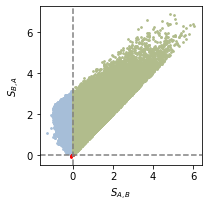

In [4]:
f1="/Users/rosamartinezcorral/Dropbox (HMS)/data/magic-kinsynsub1/randomsamplingjuly27/2020_07_27/final_results"
f2="/Users/rosamartinezcorral/Dropbox (HMS)/data/magic-kinsynsub1/randomsamplingjuly31/2020_07_31/final_results"
fc1=10
fc2=10
minb=0
maxb=4
parfc=3
alldfs=[]
nit=1000000

green="#c6cdad"
blue="#d3dbe4"
red="#e3cbc8"

green2="#b1bc8c"
blue2="#a6bed8"

for seed in range(10):

    title="minb=%g_maxb=%g_parfc=%s_fc1=%s_fc2=%s"%(minb,maxb,parfc,fc1,fc2)
    if seed <3:
        f_=os.path.join(f1,"2020_0727_randompoints_nit=%d_%s_seed=%d.df"%(nit,title,seed))
    else:
        f_=os.path.join(f2,"2020_0727_randompoints_nit=%d_%s_seed=%d.df"%(nit,title,seed))
    df=pd.read_csv(f_)
    ok=check_constraints(df,minb=minb,maxb=maxb,parfc=parfc,fc1=fc1,fc2=fc2)
    alldfs.append(df)
df=pd.concat(alldfs)
fig,ax=plt.subplots(1,1,figsize=(3,3))
mask1=df["quadrant"]==1
mask2=df["quadrant"]==2
mask3=df["quadrant"]==3
ax.scatter(df["SAB"].values[mask2],df["SBA"].values[mask2],s=3,color=blue2)
ax.scatter(df["SAB"].values[mask1],df["SBA"].values[mask1],s=3,color=green2)
ax.scatter(df["SAB"].values[mask3],df["SBA"].values[mask3],s=3,color="red")
ax.set_xlabel('$S_{A,B}$')
ax.set_ylabel('$S_{B,A}$')
ax.axhline(y=0,linestyle="--",color="gray")
ax.axvline(x=0,linestyle="--",color="gray")
ax.set_xticks(np.arange(0,7,2))
ax.set_yticks(np.arange(0,7,2))
plt.tight_layout()
plt.show()

# Distance between TFs and relationship to quadrant.

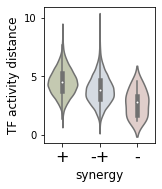

In [5]:
###
#Make together the same plot for the different conditions
kind='violin'
height=3.
synlabels=["+","-+","-"]
fontsize=12
subset_=df
step1_1=np.abs(np.log10(subset_["p8"])-np.log10(subset_["p12"])).values
step1_2=np.abs(np.log10(subset_["p7"])-np.log10(subset_["p11"])).values
step2=np.abs(np.log10(subset_["p5"])-np.log10(subset_["p9"])).values
step3=np.abs(np.log10(subset_["p6"])-np.log10(subset_["p10"])).values
distance=step1_1+step1_2+step2+step3
quadrant=subset_["quadrant"]

df_=pd.DataFrame({"distance":distance,"quadrant":quadrant})
fig,ax=plt.subplots(1,1,figsize=(2.,2.5))
plot=sns.catplot(x="quadrant",y="distance",data=df_,kind=kind,palette=[green,blue,red],height=height,ax=ax)
synlabels=["+","-+","-"]
ax.set_xticklabels(synlabels, rotation=0,fontsize=fontsize+4)
ax.set_xlabel("synergy",fontsize=fontsize)
ax.set_ylabel("TF activity distance",fontsize=fontsize)
ax.set_yticks([0,5,10])
name=""
plt.close(2)
#plt.savefig("figs/distance.pdf")
plt.show()

# Boxplots for effect of basal expression and binding

251.40227098320264
plotidx is 0
plotidx is 1
plotidx is 2


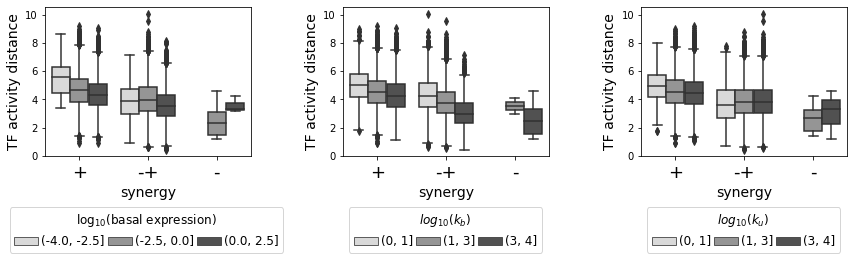

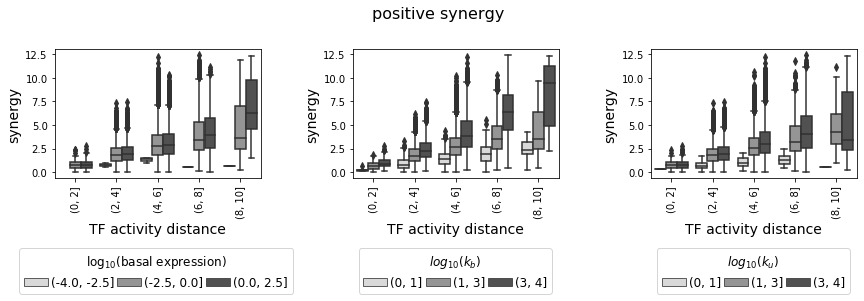

In [6]:
#Fig S1

fontsize=14
subset_=df
kind="box"

step1_1=np.abs(np.log10(subset_["p8"])-np.log10(subset_["p12"])).values
step1_2=np.abs(np.log10(subset_["p7"])-np.log10(subset_["p11"])).values
step2=np.abs(np.log10(subset_["p5"])-np.log10(subset_["p9"])).values
step3=np.abs(np.log10(subset_["p6"])-np.log10(subset_["p10"])).values
distance=step1_1+step1_2+step2+step3
totalsyn=(np.abs(subset_["SAB"])+np.abs(subset_["SBA"])).values

m0=subset_["m0"]
print(max(m0))
kb=subset_["p13"]#it doesn't matter to which step since it is the same for all
ku=subset_["p14"]
kbku=kb/ku
quadrant=subset_["quadrant"]
cmap=plt.cm.seismic
colorvars=[m0,kb,ku] #kbku

mask=subset_["quadrant"]==1
distance_=distance[mask]
totalsyn_=totalsyn[mask]
m0_=m0[mask]
kb_=kb[mask]
ku_=ku[mask]

colorvars_=[m0_,kb_,ku_] #kbku

binsar=[[-4,-2.5,0,2.5],[0,1,3,4],[0,1,3,4]]
legendloc2=[(-0.2,-0.5),(0,-0.5),(0,-0.5)]
legendloc1=[(-0.2,-0.3),(0,-0.3),(0,-0.3)]
colnamesdict={"m0":"log$_{10}$(basal expression)","p13":"$log_{10}(k_b)$","p14":"$log_{10}(k_u)$"}
figall,axes=plt.subplots(1,3,figsize=(12,4.))
figpositive,axesp=plt.subplots(1,3,figsize=(12,4.5))
figpositive.suptitle("positive synergy",y=1.1,fontsize=16)
for plotidx in range(3):
    print("plotidx is", plotidx)

    ax=axes[plotidx]
    cseries=colorvars[plotidx]
    car=np.log10(cseries.values)
    df_=pd.DataFrame({"distance":distance,"quadrant":quadrant,colnamesdict[cseries.name]:pd.cut(car,binsar[plotidx])})
    
    legend=False
    plot=sns.catplot(x="quadrant",y="distance",data=df_,hue=colnamesdict[cseries.name],palette='Greys',kind=kind,height=height,legend=legend,ax=ax)
    ax.set_xticklabels(synlabels, rotation=0,fontsize=fontsize+4)
    ax.set_xlabel("synergy",fontsize=fontsize)
    ax.set_ylabel("TF activity distance",fontsize=fontsize)
    name=colnamesdict[cseries.name]

    #ax.legend(loc="upper left", bbox_to_anchor=(1,1),ncol=1,fontsize=10,title=name)
    ax.legend(loc='upper left',handletextpad=0.25,columnspacing=0.25,bbox_to_anchor=legendloc1[plotidx],fontsize=12,title_fontsize=12,title=name,ncol=len(binsar[plotidx]))

    plt.close(3)


    cseries=colorvars_[plotidx]
    car=np.log10(cseries.values)

    df_=pd.DataFrame({"distance":pd.cut(distance_,bins=np.arange(0,11,2)),"synergy":totalsyn_,colnamesdict[cseries.name]:pd.cut(car,binsar[plotidx])})
    ax=axesp[plotidx]
    #ax.set_title(title,fontsize=10)
    
    legend=False
    plot=sns.catplot(x="distance",y="synergy",data=df_,hue=colnamesdict[cseries.name],palette='Greys',kind=kind,height=height,aspect=2,ax=ax,legend=legend)
    ticklabels=ax.xaxis.get_majorticklabels()
    ax.set_xticklabels(ticklabels,rotation=90)
    ax.set_xlabel("TF activity distance",fontsize=fontsize)
    ax.set_ylabel("synergy",fontsize=fontsize)
    ax.legend(loc='upper left',handletextpad=0.25,columnspacing=0.25,bbox_to_anchor=legendloc2[plotidx],title_fontsize=12,fontsize=12,title=colnamesdict[cseries.name],ncol=len(binsar[plotidx]))
    plt.close(3)

figall.tight_layout()
figpositive.tight_layout()
plt.show()

In [7]:
min_nflog=-13
node0=2
plotting=True
nit=1000000
paths_dict=dict()

constraints=[0,4,3]
minb,maxb,parfc=constraints
fc1,fc2=[10,10]
alldfs=[]
for seed in range(10):

    title="minb=%g_maxb=%g_parfc=%s_fc1=%s_fc2=%s"%(minb,maxb,parfc,fc1,fc2)
    if seed<3:
        f_=os.path.join(f1,"2020_0727_randompoints_nit=%d_%s_seed=%d.df"%(nit,title,seed))
    else:
        f_=os.path.join(f2,"2020_0727_randompoints_nit=%d_%s_seed=%d.df"%(nit,title,seed))
    df=pd.read_csv(f_)
    #print(df.columns)
    #plt.scatter(df["SAB"],df["SBA"])
    #plt.show()
    alldfs.append(df)
df=pd.concat(alldfs)
print("npoints",len(df))
#ok=check_constraints(df,minb=minb,maxb=maxb,parfc=parfc,fc1=fc1,fc2=fc2)

#Plot distribution of synergies per most dominant paths, irrespective of the quadrant.

paths_dict[i]=dict()


subset=df[(np.abs(df["SAB"])>0.001)&(np.abs(df["SBA"])>0.001)]
print("npoints subset", len(subset))
smatall,labls_=fluxes.get_mat_fluxes_abonly(subset,all_fnames,netJ=True,rhofunc=rhofunc,graph_edges=edges_)
#list of indexes to get the mirror graph. A and B are exchanged.
idxs_rev=[]
for l,lab_ in enumerate(labls_):
    lab_s,ext=lab_.split(".")
    if lab_s in edges_sym.keys():
        newlab=edges_sym[lab_s]+"."+ext
        idx=np.where(labls_==newlab)[0][0]
        idxs_rev.append(idx)
    else:
        idxs_rev.append(l)
#print(labls_)
#print(labls_[idxs_rev])
idxs_rev=np.array(idxs_rev)

mat_dominant_paths_all=fluxes.get_dominant_paths_mat_v4(smatall,labls_,node0)


#2. select sample, in this case all points
subset2=subset
SAB_values=subset2['SAB'].values
SBA_values=subset2['SBA'].values
quadrants=subset2["quadrant"].values
#plt.scatter(subset2["SAB"],subset2["SBA"])
#plt.show()
smat=smatall #[mask]
mat_dominant_paths=mat_dominant_paths_all #[mask]

result=np.unique(mat_dominant_paths,axis=0,return_inverse=True,return_counts=True)
alluniques=fluxes.merge_mirrored_unique_paths(mat_dominant_paths,result,idxs_rev)
paths_dict[i]=[title,alluniques,smat,quadrants,SAB_values,SBA_values]

npoints 67146
npoints subset 67055


In [8]:
#Check the dominant path for a random parameter set
print(",".join(map(str,subset.iloc[10].values[0:24])))
print(smatall[10])
print(mat_dominant_paths[10])


6.58058497661678,1.863887216557728,454.87113993982393,41.335538949352795,649.7350493047204,4.616122406569082,2.336091910537856,7578.876583401123,49.579230418419925,3.7851614540197382,1.9175362924836588,5795.057486289139,58.98351144670961,3704.721328722637,58.98351144670961,3704.721328722637,58.98351144670961,3704.721328722637,58.98351144670961,3704.721328722637,58.98351144670961,3704.721328722637,58.98351144670961,3704.721328722637
[ 1.45505442  0.          0.          0.23643605 10.03726921  0.
  0.          0.          5.46921804  6.02310559  0.05373453  0.04710051
  5.41548351  0.10083504  0.          0.          5.51631855  1.16488384
  0.05882504  4.85822175  1.22370889  0.          0.          6.08193063]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]


In [9]:
green="#c6cdad"
blue="#d3dbe4"
red="#e3cbc8"

xlim=7
ylim=7
cmapgreys=truncate_colormap(plt.cm.Greys,minval=0.2,maxval=1.0)
key=3
percent=0.6

title,alluniques,smat,quadrants,SAB_values,SBA_values=paths_dict[key]
    
#4. Now identify and plot paths for the percent threshold
    

unique_paths,idxsup,countup,mirror=alluniques
total=np.sum(countup)
argsort=np.argsort(countup)[::-1]
sorted_counts=countup[argsort]


m_allGs=[] #graphs for each instance with the dominant path
dominantG=[] #dominant graphs
corresponding_synergies=[] #corresponding synergies for each path
cumsum=np.cumsum(countup[argsort])
threshold=np.where(cumsum>percent*total)[0][0]
#print(cumsum)
#print('total', total,percent*total,'threshold',threshold,countup[argsort[0:threshold]], '+1?', countup[argsort[0:threshold+1]])
if threshold==0:
    threshold=1
for inum,i in enumerate(argsort[0:threshold]):
    #print(inum)
    #get correaponding graph for each path

    path=unique_paths[i]

    #print(countup[i],"out of ", total, "in the quadrant. In total it appears ", ntotal) 
    original_idxs=np.where(idxsup==i)[0] #positions where this path was
    quadrants_p=quadrants[original_idxs]
    #print("count is,", countup[i], "original indexes len is", len(original_idxs))
    #find fluxes corresponding to this path
    #smat_=smat[quadrants==q+1].copy()
    smat_=smat[original_idxs].copy()
    mirror_=mirror[original_idxs]
    if np.any(mirror_):
        idxs_mirror=np.where(mirror_==True)[0]
        #print("mirror", idxs_mirror)
        if len(smat_[idxs_mirror])>1:
            #print("more than 1")
            smat_[idxs_mirror]=smat_[idxs_mirror][:,idxs_rev]
        else:
            #print("only 1")
            smat_[idxs_mirror]=smat_[idxs_mirror,idxs_rev]


    matnfi=np.log10(smat_)
    matnfi[matnfi<min_nflog]=min_nflog


    #get graphs that share this dominant path
    #
    all_Gs=[]
    for row in matnfi:
        #Gs=[]
        J=row
        edgelabls=labls_
        G=fluxes.get_graph_fromJarray(J,edgelabls,min_=min_nflog)
        all_Gs.append(G)
    #average log10 of fluxes
    common_U=fluxes.merge_graphs(all_Gs)
    dominant=fluxes.get_dominant_path_G(G,node0) #since all have the same dominant path, use the last one
    m_allGs.append(common_U)
    dominantG.append(dominant)
    #allranks[q][pc].append([path,countup[i],all_Gs])
    #mask=(quadrants==q+1)
    SABoriginal=SAB_values[original_idxs]
    SBAoriginal=SBA_values[original_idxs]
    print('path %d, %d instances'%(i,len(original_idxs)))

    corresponding_synergies.append([SABoriginal,SBAoriginal])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10


path 6, 20622 instances
path 7, 14495 instances


[(2, 8), (8, 7), (7, 1), (1, 2)]
[(2, 5), (5, 4), (4, 3), (3, 0), (0, 6), (6, 8), (8, 2)]


//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
//anaconda3/li

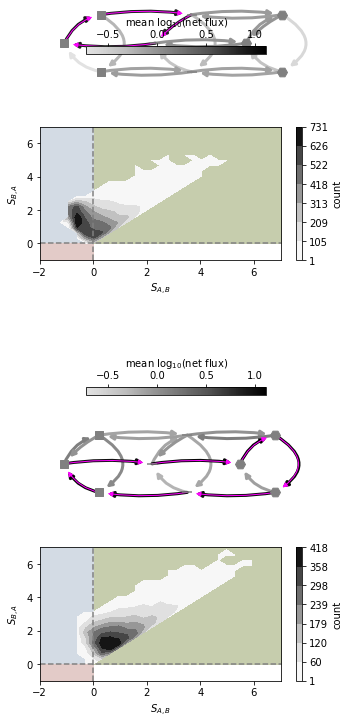

In [10]:
#plot
#Fig2 main
nc=4
nr=2
fig=plt.figure(figsize=(5,11))
gs=mpl.gridspec.GridSpec(13,4)

#fig.suptitle("%s,percent %g"%(title,percent),y=1.05)


mins=[min([G[e[0]][e[1]]["weight"] for e in G.edges]) for G in m_allGs]
minv=min(mins)

maxs=[max([G[e[0]][e[1]]["weight"] for e in G.edges]) for G in m_allGs]
maxv=max(maxs)


for inum in range(len(m_allGs)):
    row=inum
    ax=fig.add_subplot(gs[7*row+1:7*row+3,0:4]) #axes_[2*row][col]
    #ax.set_title("%g"%(countup[argsort[inum]]/total),fontsize=10)
    #print(inum)

    #In this case graphs may have different connectivity
    G=m_allGs[inum]
    colors_=[G[e[0]][e[1]]["weight"] for e in G.edges]
    G2=dominantG[inum]
    print(G2.edges())
    #print(minv,colors_w)
    fluxes.plot_graphs([G],[ax],coords=coords,color_lists=[colors_],dominant=[G2],color_args={"edge_cmap":cmapgreys,"edge_vmin":minv,"edge_vmax":maxv,"width":3},colord="magenta")
    ax.set_frame_on(False)
    #cax=fig.add_axes([1,0.6,0.01,0.3])
    norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
    cwidth=0.85/nc
    if inum==0:
        ypos=0.85
    else:
        ypos=0.42
    cax=fig.add_axes([0.25,ypos,0.5,0.01])
    #cax=fig.add_axes([(col)*(1/nc)+cwidth,0.65,0.01,0.25])
    cb=mpl.colorbar.ColorbarBase(cmap=cmapgreys,norm=norm,ax=cax,orientation='horizontal',label="mean $\log_{10}$(net flux)",ticks=[-0.5,0,0.5,1],ticklocation="top")
    #cb.ax.set_yticks()
    #cb.yaxes.set_ylabel()

    ax=fig.add_subplot(gs[7*row+3:7*row+6,0:4])
    #patch=plt.Polygon([[0,0],[5,0],[5,5],[0,5]],color=green)
    #ax.add_patch(patch)
    ax.fill_between([0,xlim],0,ylim,color=green)
    ax.fill_between([-2,0],0,ylim,color=blue)
    ax.fill_between([-2,0],0,-1,color=red)
    x=corresponding_synergies[inum][0]
    y=corresponding_synergies[inum][1]
    H,xbins,ybins=np.histogram2d(y,x,bins=[np.linspace(-2,xlim,30),np.linspace(-2,ylim,30)])
    mask=H<1
    #mask1=
    cmap1=plt.cm.Greys
    #cmap1.set_under(green)
    #cmap1.set_bad(green)
    #ax.contourf(H,8,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],origin="lower",cmap=cmap1,zorder=2)
    levels=list(map(int,np.linspace(1,np.max(H),8)))
    cf=ax.contourf(np.ma.masked_array(H,mask=mask),levels,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],vmin=1,origin="lower",cmap=cmap1,zorder=2)
    plt.colorbar(cf,ax=ax,label="count")
    #contours.append(cf)
    #ax.imshow(np.ma.masked_array(H,mask=mask),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],origin="lower",cmap=cmap1,zorder=2)
    #sns.kdeplot(*corresponding_synergies[inum],ax=ax,shade=True,cbar=True,cmap=plt.cm.Greys)
    ax.axvline(x=0,linestyle="--",color="gray",zorder=2)
    ax.axhline(y=0,linestyle="--",color="gray",zorder=2)
    ax.set_xlabel(r'$S_{A,B}$')
    ax.set_ylabel(r'$S_{B,A}$')
    ax.set_xlim(-2,xlim)
    ax.set_ylim(-1,ylim)
#
#norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
#mpl.colorbar.ColorbarBase(cmap=cmap,norm=norm,ax=cax,orientation='vertical')
#cax.set_ylabel()

#cax=fig.add_axes([1,0.1,0.01,0.3])
#norm = mpl.colors.Normalize(vmin=2,vmax=maxH)
#mpl.colorbar.ColorbarBase(cmap=cmap,norm=norm,ax=cax,orientation='vertical')
#cax.set_ylabel("count")

plt.tight_layout()
#plt.savefig("figs/Fig2fluxes.pdf")
plt.show()

In [11]:
#Now sort according to fluxes
#Fig S1
green="#c6cdad"
blue="#d3dbe4"
red="#e3cbc8"

xlim=7
ylim=7
cmapgreys=truncate_colormap(plt.cm.Greys,minval=0.2,maxval=1.0)

key=3
percent=0.9
title,alluniques,smat,quadrants,SAB_values,SBA_values=paths_dict[key]


#print("seed", seed, "percent", percent)
#for q in range(3):

unique_paths,idxsup,countup,mirror=alluniques
total=np.sum(countup)
argsort=np.argsort(countup)[::-1]
counts_sorted=countup[argsort]
#print(countup[argsort])


m_allGs=[] #graphs for each instance with the dominant path
dominantG=[] #dominant graphs
corresponding_synergies=[] #corresponding synergies for each path
percentage_positive=[]
cumsum=np.cumsum(counts_sorted)
threshold=np.where(cumsum>percent*total)[0][0]
#print(cumsum)
#print('total', total,percent*total,'threshold',threshold,countup[argsort[0:threshold]], '+1?', countup[argsort[0:threshold+1]])
if threshold==0:
    threshold=1
    
for inum,i in enumerate(argsort[0:threshold]):
    #print(inum)
    #get correaponding graph for each path

    path=unique_paths[i]

    #print(countup[i],"out of ", total, "in the quadrant. In total it appears ", ntotal) 
    original_idxs=np.where(idxsup==i)[0] #positions where this path was
    quadrants_p=quadrants[original_idxs]
    #print("count is,", countup[i], "original indexes len is", len(original_idxs))
    #find fluxes corresponding to this path
    #smat_=smat[quadrants==q+1].copy()
    smat_=smat[original_idxs].copy()
    mirror_=mirror[original_idxs]
    if np.any(mirror_):
        idxs_mirror=np.where(mirror_==True)[0]
        #print("mirror", idxs_mirror)
        if len(smat_[idxs_mirror])>1:
            #print("more than 1")
            smat_[idxs_mirror]=smat_[idxs_mirror][:,idxs_rev]
        else:
            #print("only 1")
            smat_[idxs_mirror]=smat_[idxs_mirror,idxs_rev]


    matnfi=np.log10(smat_)
    matnfi[matnfi<min_nflog]=min_nflog


    #get graphs that share this dominant path
    all_Gs=[]
    for row in matnfi:
        #Gs=[]
        J=row
        edgelabls=labls_
        G=fluxes.get_graph_fromJarray(J,edgelabls,min_=min_nflog)

        #Gs.append(G)
        #all_Gs.append(Gs)

        all_Gs.append(G)
    common_U=fluxes.merge_graphs(all_Gs)
    dominant=fluxes.get_dominant_path_G(G,node0) #since all have the same dominant path, use the last one
    m_allGs.append(common_U)
    dominantG.append(dominant)
    #allranks[q][pc].append([path,countup[i],all_Gs])
    #mask=(quadrants==q+1)
    SABoriginal=SAB_values[original_idxs]
    SBAoriginal=SBA_values[original_idxs]
    print('path %d, %d instances'%(i,len(original_idxs)))

    corresponding_synergies.append([SABoriginal,SBAoriginal])
    percentage_positive.append(np.sum(SABoriginal>0)/len(SABoriginal))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log10


path 6, 20622 instances
path 7, 14495 instances
path 23, 5127 instances
path 10, 4177 instances
path 14, 4003 instances
path 3, 3311 instances
path 0, 2170 instances
path 9, 1828 instances
path 16, 1672 instances
path 8, 1134 instances
path 26, 1095 instances


first items 6
0 0 0
1 0 1
2 0 2


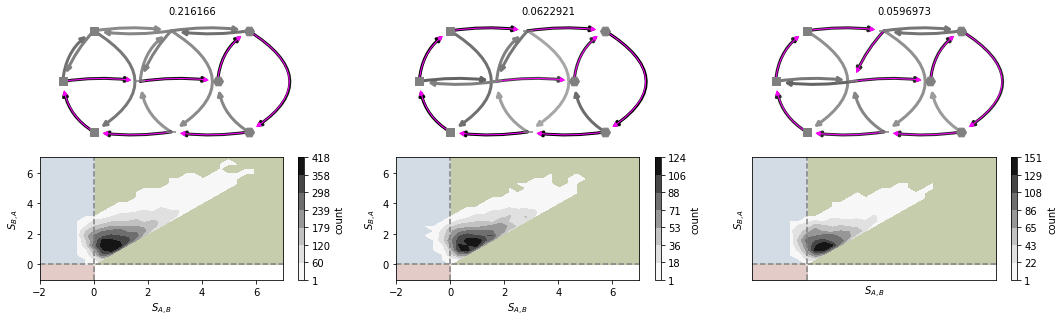

3 1 0
4 1 1
5 1 2


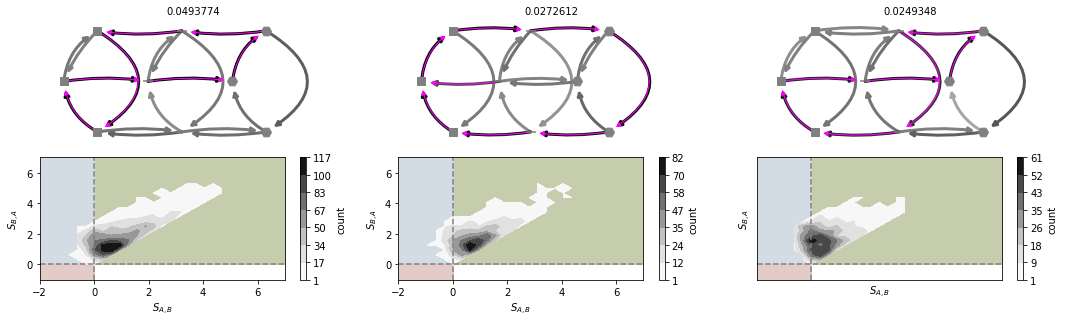

6 2 0
7 2 1
8 2 2


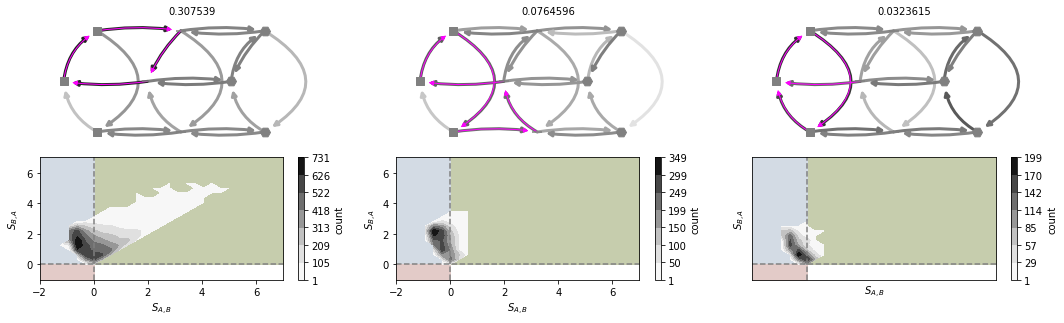

9 3 0
10 3 1


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


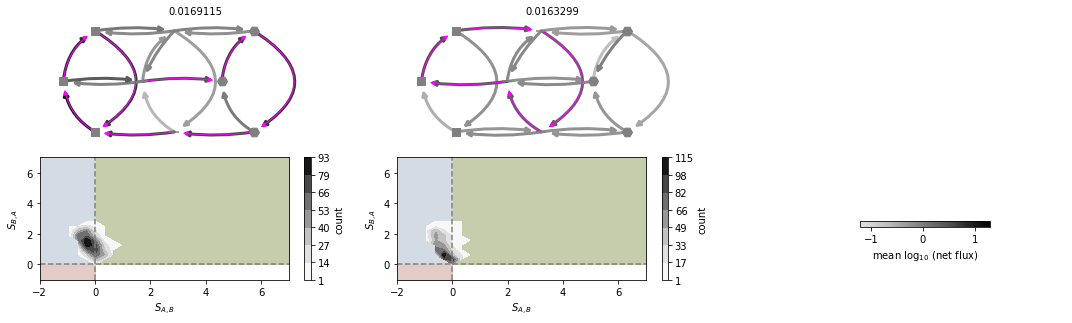

In [12]:
#plot
m=5
max_nflog=np.log10(np.max(smat))
#cmap=plt.cm.summer_r
cmap=plt.cm.Greys



#gs=mpl.gridspec.GridSpec(6*nr,nc)

#fig.suptitle("%s,percent %g"%(title,percent),y=1.05)


mins=[min([G[e[0]][e[1]]["weight"] for e in G.edges]) for G in m_allGs]
minv=min(mins)

maxs=[max([G[e[0]][e[1]]["weight"] for e in G.edges]) for G in m_allGs]
maxv=max(maxs)


nr=2
nc=3

neworder=[]
#first find the ones with percentage_positive < 0.5
for i,item_ in enumerate(percentage_positive):
    if item_>=0.5:
        neworder.append(i)
print("first items", len(neworder))
for i,item_ in enumerate(percentage_positive):
    if item_<0.5:
        neworder.append(i)
pltnum=1
for i,inum in enumerate(neworder):
    
    row=i//nc
    col=i%nc
    if col==0:
        if i>0:
            plt.tight_layout()
            #plt.savefig("figs/fluxessuppl%d.pdf"%pltnum,bbox_inches="tight")
            plt.show()
            pltnum+=1
        fig,axes=plt.subplots(nr,nc,figsize=(5*nc,2.3*nr))
    print(i,row,col)
    ax=axes[0,col]
    #ax=fig.add_subplot(gs[row:row+5,col:col+1]) #axes_[2*row][col]
    ax.set_title("%g"%(counts_sorted[inum]/total),fontsize=10)
    #print(inum)

    #In this case graphs may have different connectivity
    G=m_allGs[inum]
    colors_=[G[e[0]][e[1]]["weight"] for e in G.edges]
    G2=dominantG[inum]
    #print(minv,colors_w)
    fluxes.plot_graphs([G],[ax],coords=coords,color_lists=[colors_],dominant=[G2],color_args={"edge_cmap":cmapgreys,"edge_vmin":minv,"edge_vmax":maxv,"width":3},colord="magenta")
    ax.set_frame_on(False)
    #cax=fig.add_axes([1,0.6,0.01,0.3])
    #norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
    #cwidth=0.85/nc
    #cax=fig.add_axes([(col)*(1/nc)+cwidth,1-row*1/nr,0.01,0.9/nr])
    #cb=mpl.colorbar.ColorbarBase(cmap=cmapgreys,norm=norm,ax=cax,orientation='vertical',label="mean\n$\log_{10}$ (net flux)",ticks=[-0.5,0,1])
    #cb.ax.set_yticks()
    #cb.yaxes.set_ylabel()

    ax=axes[1,col]
    #ax=fig.add_subplot(gs[6*row+5:,col:col+1])
    #patch=plt.Polygon([[0,0],[5,0],[5,5],[0,5]],color=green)
    #ax.add_patch(patch)
    ax.fill_between([0,xlim],0,ylim,color=green)
    ax.fill_between([-2,0],0,ylim,color=blue)
    ax.fill_between([-2,0],0,-1,color=red)
    x=corresponding_synergies[inum][0]
    y=corresponding_synergies[inum][1]
    H,xbins,ybins=np.histogram2d(y,x,bins=[np.linspace(-2,xlim,30),np.linspace(-2,ylim,30)])
    mask=H<1
    #mask1=
    cmap1=plt.cm.Greys
    #cmap1.set_under(green)
    #cmap1.set_bad(green)
    #ax.contourf(H,8,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],origin="lower",cmap=cmap1,zorder=2)
    levels=list(map(int,np.linspace(1,np.max(H),8)))
    cf=ax.contourf(np.ma.masked_array(H,mask=mask),levels,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],vmin=1,origin="lower",cmap=cmap1,zorder=2)
    plt.colorbar(cf,ax=ax,label="count")
    #contours.append(cf)
    #ax.imshow(np.ma.masked_array(H,mask=mask),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],origin="lower",cmap=cmap1,zorder=2)
    #sns.kdeplot(*corresponding_synergies[inum],ax=ax,shade=True,cbar=True,cmap=plt.cm.Greys)
    ax.axvline(x=0,linestyle="--",color="gray",zorder=2)
    ax.axhline(y=0,linestyle="--",color="gray",zorder=2)
    ax.set_xlabel(r'$S_{A,B}$')
    ax.set_ylabel(r'$S_{B,A}$')
    ax.set_xlim(-2,xlim)
    ax.set_ylim(-1,ylim)

#plt.tight_layout()
#plt.show()
#norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
#mpl.colorbar.ColorbarBase(cmap=cmap,norm=norm,ax=cax,orientation='vertical')
#cax.set_ylabel()
#inum=11
#row=inum//nc
#col=inum%nc
#fig,ax=plt.subplots(1,1,)
ax=axes[0,2]
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

ax=axes[1,2]
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])


cax=fig.add_axes([0.8,0.3,0.12,0.02])
norm = mpl.colors.Normalize(vmin=minv,vmax=maxv)
mpl.colorbar.ColorbarBase(cmap=cmapgreys,norm=norm,ax=cax,orientation='horizontal',label="mean $\log_{10}$ (net flux)")
#cax.set_ylabel("count")

plt.tight_layout()
#plt.savefig("figs/fluxessuppl%d.pdf"%pltnum,bbox_inches="tight")
plt.show()

[-0.502745012129063, 0.5961060278335213, -1.3212015405027635, 0.5669035339305876, 0.6347028133404956, -0.5871304012445793, -0.5057460540216706, 0.6389143280978352, 0.6066165425966745, 0.5343373605537031, -0.05071397025026958, -0.28142839726823554, -0.43568583919194515, 0.6021715778636081, -0.4519401821904936]


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


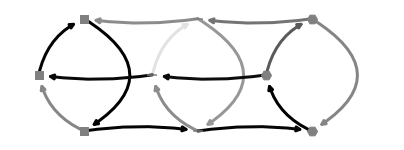

-1.3212015405027635 0.6389143280978352


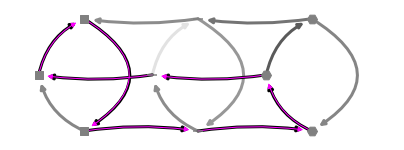

[0.35234152836541915, 0.05316566715619237, 0.13422777905502364, -0.41360321270676065, -0.2985750820555652, 0.12088379085962699, 0.19300041601210083, 0.12013368954318875, 0.40302819710593746, 0.23217572150251511, 0.08307227510200793, 0.1807157241139062, -0.7196147938872564, 0.26042844335760035, -0.1499880339221315]


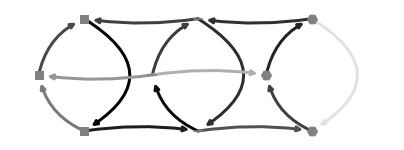

-0.7196147938872564 0.40302819710593746


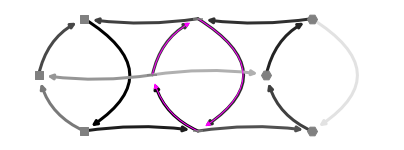

[-0.8193489274164054, 1.227305995395863, 1.738628829390072, 1.4300631701928423, 0.7225475547293165, 1.5399060377396923, 0.4893499224520545, 1.0018135449411327, 1.746938657145813, 1.3002277803865216, 0.8423703474293661, 1.070039740149383, 0.024598078905146908, 1.6337794931918013, 1.107492324440964]


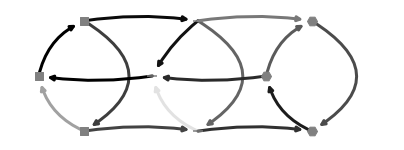

-0.8193489274164054 1.746938657145813


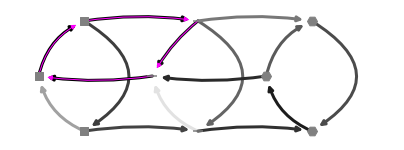

[0.2781018653467873, 0.5310171123803528, 0.8785310978655867, 0.7293054622942271, 0.2576693983335818, 0.1657530406979851, -0.09587446356416153, 0.2934398792325658, 0.905331005602883, 0.5420252458472373, -0.31765105462331533, 0.6102966391210903, 0.598221448343397, 0.6230730943452075, 0.06574401481698079]


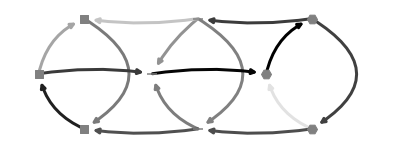

-0.31765105462331533 0.905331005602883


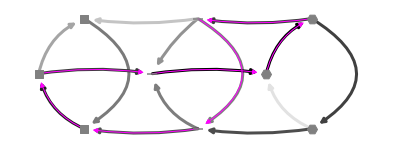

[0.09268031436725886, -1.8102523162303659, -1.3204875515985304, 0.13307103173217005, -1.683552713332949, -0.5459657694118228, -0.773503479106163, -1.1641062632607955, 0.18613109185468135, -1.1986753520049722, -2.28037254182932, -0.013722980975761847, -0.7531454358116499, -0.4093365243780481, 0.058972470218337326]


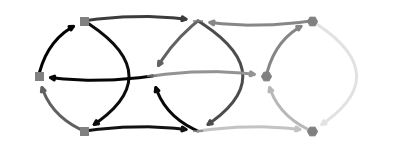

-2.28037254182932 0.18613109185468135


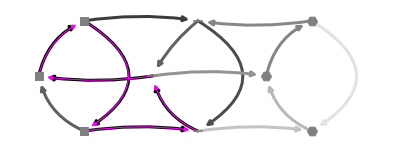

[-0.5832794004359313, -0.7245678056515409, -1.0790853457555376, 0.06214240347708255, -0.07282176610543027, 0.09359852307846903, -0.2733116339276957, -0.23817247853294868, -0.8983751421783911, -0.18238613929624378, 0.37918519409413426, -0.501804045202237, -0.2751436070678526, 0.09243403841715202, 0.0633908886459004]


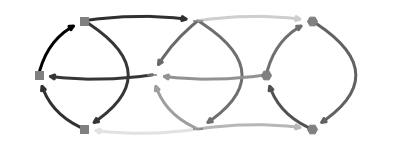

-1.0790853457555376 0.37918519409413426


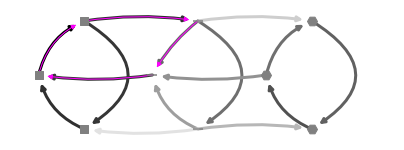

[0.36888888857764884, 0.1996540267515487, 0.8538261558292427, 0.5320630740284825, 0.4357599396274958, -0.21064041650105433, 0.9142606888172993, 0.9942983856414747, 0.6465811671443442, 0.9408020136775892, 0.058364753545332444, 0.5193269703700308, 0.011669397496415894, -1.0070371416683974, 0.6368305480644816]


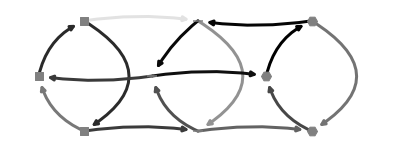

-1.0070371416683974 0.9942983856414747


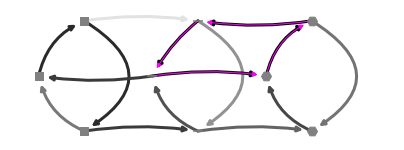

[0.04111773733720319, -0.7866350151634759, -0.4642873472794648, 0.04131237526802516, -0.3161380585378557, -0.45503435824471544, -0.4636644471818311, -0.08289589835002457, 0.05804767787083853, -0.2951863547268274, -0.495579746201148, -0.03999459489843287, -1.364443845271367, -0.7263635791974539, -0.019892322415922443]


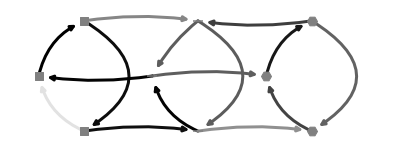

-1.364443845271367 0.05804767787083853


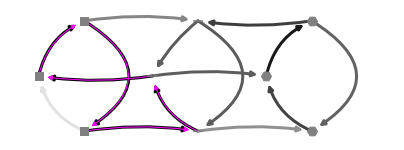

[-0.9474074880787099, -0.11902914066847003, 1.1104483386714752, -0.07048892837568914, -0.13316265578795175, 0.927467890146917, 0.6491639591644386, 0.6511525288156736, 1.1381757658097487, 1.1353259484428035, -1.046215646237326, -0.8625905658282678, 0.6376386305665372, 0.6355870613178661, -1.6890848808218941]


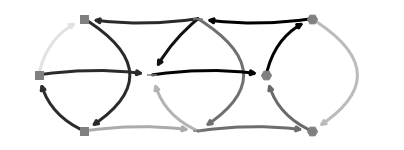

-1.6890848808218941 1.1381757658097487


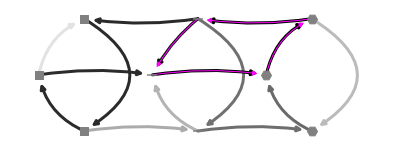

[-0.7231044305505604, 1.3323456286576127, -0.9754735259967988, 1.2098763893163043, 1.5850301962017084, -0.6409964158016633, 0.7195422792614699, 1.4255418293593618, 1.330371567265269, 1.3315494066713527, 0.7147014183669415, 1.207637238763509, 1.3489226735946427, 0.7295938632330159, 1.2295909179018636]


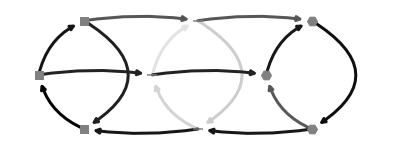

-0.9754735259967988 1.5850301962017084


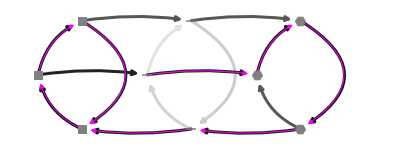

In [13]:
np.random.seed(1)
for i in np.random.choice(range(len(smat)),size=10,replace=False):
    matnfi=np.log10(smat[i])
    matnfi[matnfi<min_nflog]=min_nflog
    J=matnfi
    edgelabls=labls_
    G=fluxes.get_graph_fromJarray(J,edgelabls,min_=min_nflog)
    colors_=[G[e[0]][e[1]]["weight"] for e in G.edges]
    print(colors_)
    fig,ax=plt.subplots(1,1,figsize=(7,2.5))
    G2=fluxes.get_dominant_path_G(G,node0)
    minv=min(colors_)
    maxv=max(colors_)
    fluxes.plot_graphs([G],[ax],coords=coords,color_lists=[colors_],dominant=[],color_args={"edge_cmap":cmapgreys,"edge_vmin":minv,"edge_vmax":maxv,"width":3},colord="magenta")
    ax.set_frame_on(False)
    plt.show()
    fig,ax=plt.subplots(1,1,figsize=(7,2.5))
    G2=fluxes.get_dominant_path_G(G,node0)
    print(minv,maxv)
    fluxes.plot_graphs([G],[ax],coords=coords,color_lists=[colors_],dominant=[G2],color_args={"edge_cmap":cmapgreys,"edge_vmin":minv,"edge_vmax":maxv,"width":3},colord="magenta")
    ax.set_frame_on(False)
    plt.show()
